In [1]:
import numpy as np
import matplotlib.pyplot as plt

import py4DSTEM
from py4DSTEM.process.datastructure import RealSlice, DiffractionSlice, PointList, DataCube

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.h5"
dc = py4DSTEM.readwrite.read_data(fp)

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.h5...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.h5 is a py4DSTEM HDF5 file.  Reading...


### Make a few DataObjects
- one RawDataCube
- two RealSlice
- three DiffractionSlices; two with depth > 1, one with named slices
- two PointLists
- one processed DataCube

In [3]:
# RealSlice: ROI (boolean)

xmin,xmax=0,4
ymin,ymax=5,9

data = np.zeros_like(dc.data4D[:,:,0,0],dtype=bool)
data[xmin:xmax,ymin:ymax] = True

ROI = RealSlice(data,dc)

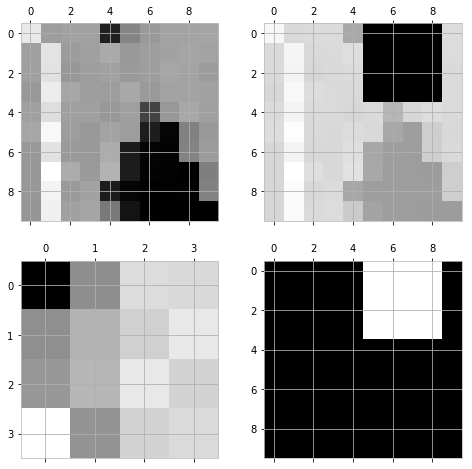

In [4]:
# Show

ave_im = np.average(dc.data4D,axis=(2,3))

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(8,8))
ax11.matshow(ave_im,cmap='gray')
ax12.matshow(ave_im*(ROI.data2D==False),cmap='gray')
ax21.matshow(ave_im[ROI.data2D].reshape(xmax-xmin,ymax-ymin),cmap='gray')
ax22.matshow(ROI.data2D)
plt.show()

In [5]:
# DiffractionSlice: Probe Template

length = ROI.data2D.sum()
ref_DP = dc.data4D[ROI.data2D,:,:][0]

for n in range(1,length):
    curr_DP = dc.data4D[ROI.data2D,:,:][n]
    
    xshift,yshift = py4DSTEM.process.utils.get_shift(ref_DP, curr_DP)
    curr_DP_shifted = py4DSTEM.process.utils.get_shifted_ar(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

probe_template = DiffractionSlice(ref_DP,dc,name='probe template')

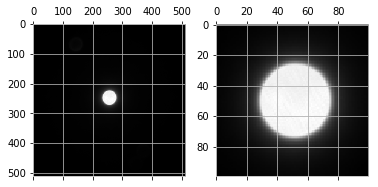

In [6]:
# Show

xCoM,yCoM = py4DSTEM.process.utils.get_CoM(probe_template.data2D)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template.data2D,cmap='gray')
ax2.matshow(probe_template.data2D[int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50])
plt.show()

In [7]:
# PointList: CoM of probe template
coords = [('qx',int),('qy',int)]
probeCoM = PointList(coordinates=coords, parentDataCube=dc, name='CoM')

new_point = (xCoM, yCoM)
probeCoM.add_point(new_point)

In [8]:
# PointList: CoMs of DPs
coords = [('rx',int),('ry',int),('qx',int),('qy',int)]
DP_CoMs = PointList(coordinates=coords, parentDataCube=dc, name='all CoMs')

for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        DP = dc.data4D[i,j,:,:]
        xCoM,yCoM = py4DSTEM.process.utils.get_CoM(DP)
        new_point = (i, j, xCoM, yCoM)
        DP_CoMs.add_point(new_point)

In [9]:
# DiffractionSlice: three DP

positions = ((1,5),(3,3),(4,9))
DPs = np.empty((3,dc.Q_Nx,dc.Q_Ny))
for i in range(len(positions)):
    x,y = positions[i]
    DPs[i,:,:] = dc.data4D[x,y,:,:]

diffraction_patterns = DiffractionSlice(DPs,dc,
                                       name='random diffraction patterns',
                                       save_behavior=True)

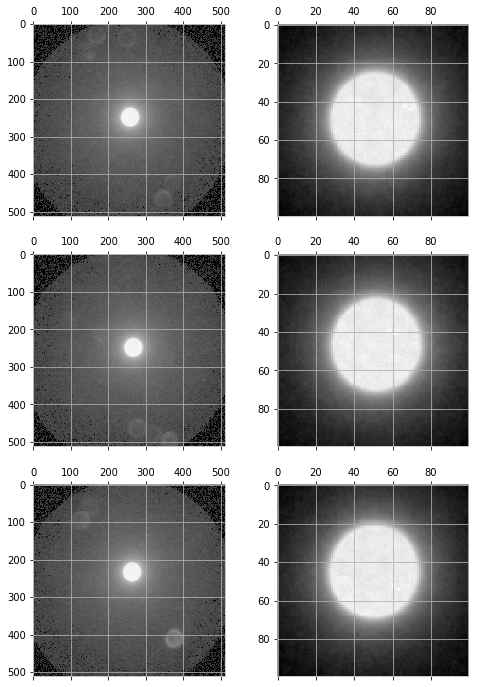

In [10]:
# Show
power=0.2

fig,axs=plt.subplots(3,2,figsize=(8,12))
for i in range(3):
    ax1,ax2 = axs[i]
    xCoM,yCoM = py4DSTEM.process.utils.get_CoM(diffraction_patterns.data2D[i])
    ax1.matshow(diffraction_patterns.data2D[i]**power,cmap='gray')
    ax2.matshow(diffraction_patterns.data2D[i][int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50]**power)
plt.show()

In [11]:
# DiffractionSlice: three DP, with names

positions = ((1,5),(3,3),(4,9))
DPs = np.empty((3,dc.Q_Nx,dc.Q_Ny))
for i in range(len(positions)):
    x,y = positions[i]
    DPs[i,:,:] = dc.data4D[x,y,:,:]

named_diffraction_patterns = DiffractionSlice(DPs,dc,
                                       name='named diffraction patterns',
                                       slicelabels=('one','two','three'))

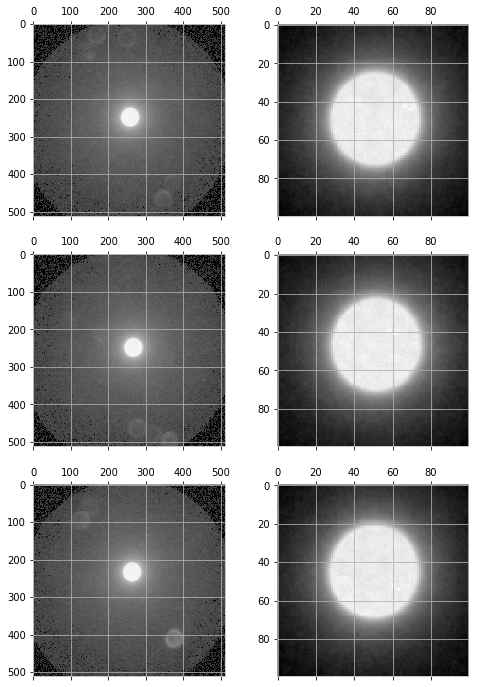

In [19]:
# Show
power=0.2

names=('one','two','three')
fig,axs=plt.subplots(3,2,figsize=(8,12))
for i in range(3):
    ax1,ax2 = axs[i]
    xCoM,yCoM = py4DSTEM.process.utils.get_CoM(named_diffraction_patterns.data2D[names[i]])
    ax1.matshow(named_diffraction_patterns.data2D[names[i]]**power,cmap='gray')
    ax2.matshow(named_diffraction_patterns.data2D[names[i]][int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50]**power)
plt.show()

In [20]:
# Processed datacube - shifted to align CoMs

xCoM_ave, yCoM_ave = np.average(DP_CoMs.data['qx']), np.average(DP_CoMs.data['qy'])

data4D_shifted = np.empty_like(dc.data4D,dtype='float32')
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        #print("Shifting DP from scan position {},{}".format(i,j))
        _,_,qx,qy = DP_CoMs.get_subpointlist([('rx',i),('ry',j)]).data[0]
        shift_qx, shift_qy = qx-xCoM_ave, qy-yCoM_ave
        data4D_shifted[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -shift_qx, -shift_qy)

dc_shifted = DataCube(data4D_shifted, dc, name='shifted data')

### DataObjectTracker

In [21]:
# Are you my mommy?

dc.dataobjecttracker.rawdatacube == dc

True

In [22]:
# Do I contain...?

print(dc.dataobjecttracker.contains_dataobject(ROI))
print(dc.dataobjecttracker.contains_dataobject(['random','list','of','things']))

True
False


In [23]:
# ...are YOU my mommy?

probe_template.has_parent(dc)

True

In [24]:
# What objects do I have?

dc.dataobjecttracker.dataobject_list

[[0,
  '',
  py4DSTEM.process.datastructure.datacube.RawDataCube,
  True,
 [1,
  '',
  py4DSTEM.process.datastructure.real.RealSlice,
  False,
 [2,
  'probe template',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
  True,
 [3,
  'CoM',
  py4DSTEM.process.datastructure.pointlist.PointList,
  False,
 [4,
  'all CoMs',
  py4DSTEM.process.datastructure.pointlist.PointList,
  False,
 [5,
  'random diffraction patterns',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
  False,
 [6,
  'named diffraction patterns',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
  True,
 [7,
  'shifted data',
  py4DSTEM.process.datastructure.datacube.DataCube,
  False,

In [25]:
# What objects do I have, for humans

dc.dataobjecttracker.get_dataobjects(show=True)
# Or:
# dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               N     
   2    probe template                      DiffractionSlice        Y     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               N     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     
   7    shifted data                        DataCube                N     


In [26]:
# Sort objects by type

dc.dataobjecttracker.sort_dataobjects_by_type(show=True)

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               N     
   2    probe template                      DiffractionSlice        Y     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               N     
   7    shifted data                        DataCube                N     


In [32]:
# Sort objects by type

dc.dataobjecttracker.sort_dataobjects_by_type(DiffractionSlice, show=True)

 Index                  Name                        Type           Save   
   2    probe template                      DiffractionSlice        Y     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     


In [33]:
# Sort objects by name

dc.dataobjecttracker.sort_dataobjects_by_name(show=True)

 Index                  Name                        Type           Save   
   2    probe template                      DiffractionSlice        Y     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               N     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     
   7    shifted data                        DataCube                N     
   0                                        RawDataCube             Y     
   1                                        RealSlice               N     


In [34]:
# Find an object by name

dc.dataobjecttracker.get_object_by_name('probe template')

In [35]:
# Find all objects containing a string

dc.dataobjecttracker.get_object_by_name('CoM')

In [36]:
# Find an object by name

dc.dataobjecttracker.get_object_by_name('CoM', exactmatch=True)

In [37]:
# Find an object by index

dc.dataobjecttracker.get_object_by_index(2)

### Tweaking the save behavior

In [38]:
# From tracker

dc.dataobjecttracker.change_save_behavior(ROI, True)
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               Y     
   2    probe template                      DiffractionSlice        Y     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               N     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     
   7    shifted data                        DataCube                N     


In [39]:
# From objects

probe_template.change_save_behavior(True)
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               Y     
   2    probe template                      DiffractionSlice        Y     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               N     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     
   7    shifted data                        DataCube                N     


In [40]:
# Change all save behaviors

dc.dataobjecttracker.change_all_save_behaviors(False)
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             N     
   1                                        RealSlice               N     
   2    probe template                      DiffractionSlice        N     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               N     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        N     
   7    shifted data                        DataCube                N     


In [41]:
dc.dataobjecttracker.change_save_behavior('all',True)
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               Y     
   2    probe template                      DiffractionSlice        Y     
   3    CoM                                 PointList               Y     
   4    all CoMs                            PointList               Y     
   5    random diffraction patterns         DiffractionSlice        Y     
   6    named diffraction patterns          DiffractionSlice        Y     
   7    shifted data                        DataCube                Y     


In [42]:
dc.dataobjecttracker.change_save_behavior([ROI,probeCoM,diffraction_patterns],False)
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               N     
   2    probe template                      DiffractionSlice        Y     
   3    CoM                                 PointList               N     
   4    all CoMs                            PointList               Y     
   5    random diffraction patterns         DiffractionSlice        N     
   6    named diffraction patterns          DiffractionSlice        Y     
   7    shifted data                        DataCube                Y     


### Saving

In [44]:
fp = "/Users/Ben/Desktop/example_manyobjects.h5"

dc.dataobjecttracker.change_save_behavior([probeCoM,DP_CoMs],False)
dc.dataobjecttracker.change_save_behavior([ROI,probe_template,diffraction_patterns,
                                           named_diffraction_patterns,dc_shifted],True)

py4DSTEM.readwrite.save_from_dataobjecttracker(dc.dataobjecttracker,fp)

Creating file /Users/Ben/Desktop/example.h5...
Writing metadata...
probe template <py4DSTEM.process.datastructure.diffraction.DiffractionSlice object at 0x12fda7dd8>
random diffraction patterns <py4DSTEM.process.datastructure.diffraction.DiffractionSlice object at 0x1281b2710>
named diffraction patterns <py4DSTEM.process.datastructure.diffraction.DiffractionSlice object at 0x12fe3f7b8>
shifted data <py4DSTEM.process.datastructure.datacube.DataCube object at 0x134611ac8>
Done.


In [40]:
dc.dataobjecttracker.dataobject_list[2][1]==''

False